# Convolutional neural network with TensorFlow 2


In Part I of the notebook, you will learn to:

- use the Sequential class for TensorFlow model definition
- implement your own training pipeline

Next, in Part II of the notebook, you will learn to:
- use the tf.data.Dataset API to build an advanced input pipeline
- use the Model class for TensorFlow model definition
- use the TensorFlow built-in training methods
- change optimizer and loss parameters in the built-in training methods


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import skimage.transform
import tensorflow as tf
from cnn_utils import *

%matplotlib inline
np.random.seed(4)

# Part I

## 1 - The SIGNS dataset

Run the next cell to load the SIGNS dataset you are going to use.

- `X_train` is the dataset used to train the model. 
- `X_test` is the dataset used to test the performance of the trained model.

Note that if you want to tune the hyperparameters of the network or if you want to apply stopping criterion based on metrics such as accuracy and loss, you need to use an additional dataset - called validation set -- to validate the model during the training process. In that case, the test and the validation sets must be disjoint sets otherwise the performance assessment would not be "fair".

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labeled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 2


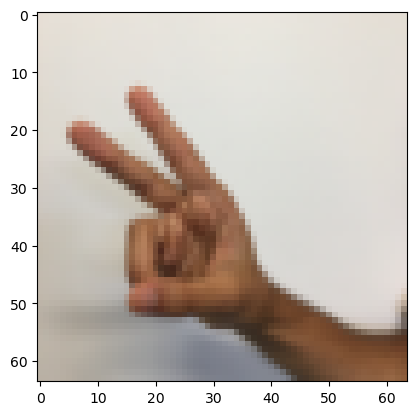

In [3]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

To get started, let's examine the shapes of the data. 

In [4]:
print("number of training examples = " + str(X_train_orig.shape[0]))
print("number of test examples = " + str(X_test_orig.shape[0]))
print("X_train shape: " + str(X_train_orig.shape))
print("Y_train shape: " + str(Y_train_orig.shape))
print("X_test shape: " + str(X_test_orig.shape))
print("Y_test shape: " + str(Y_test_orig.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (1, 120)


Pixels in each channel (RGB) of the images take values in the range \[0, 255\]. However, it is desirable to have absolute values in the range \[0, 1\] as input for neural network architectures to avoid exploding or vanishing gradient problems. Through the following cell, we apply a simple data scaling procedure: we divide the values of the pixels by 255.
As an alternative, you can use the `StandardScaler()` function of the scikit-learn library as seen in the notebook of Lab2. Note: to apply that function you need first to reshape the 4D matrices representing the data into 2D representation by flattening the 2nd, 3rd and 4th dimensions.

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

With the following cell we convert the labels into one-hot vectors. Note that this is not the only way to provide this information to the training method of TensorFlow. The other possibility is to pass directly the labels instead of their one-hot representation. We will see the latter approach in the second part of the notebook. Depending on the approach, you need to change the loss function accordingly. 

In [6]:
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

## 2 - TensorFlow model

### 2.1 - Model definition

We use the TensorFlow built-in functions that carry out the convolution steps for you.

- **`tf.keras.layers.Conv2D(filters, kernel_size, strides, padding, activation)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

- **`tf.keras.layers.BatchNormalization(axis)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

- **`tf.keras.layers.MaxPool2D(pool_size, strides, padding)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

- **`tf.keras.layers.flatten()`**: You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)


- **`tf.keras.layers.Dense(units, activation)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)


**Exercise**: 

Implement your model! There are two ways to do that in TensorFlow (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/models)). In this first part of the notebook you will use the `Sequential` class while in the second part we will see the `Model` class. 

Use **tf.keras.Sequential([layer1, layer2, ...])** to build the model. 
```python
network_model = tf.keras.Sequential([tf.keras.layers.Conv2D(8, (3, 3), strides=(1,1), padding='same', activation=None), tf.keras.layers.BatchNormalization(axis=-1), ..., ...])
```

Full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

You can start with the following structure and then try to experiment with different hyperparameters:

     - Conv2D: 4 channels at output, 3 by 3 filter size, stride 1, padding is "SAME"
     - BatchNormalization
     - ReLU activation
     - Max pool: 2 by 2 filter size, 2 by 2 stride, padding is "SAME"
     - Conv2D: 8 channels at output, 3 by 3 filter size, stride 1, padding is "SAME"
     - BatchNormalization
     - ReLU activation
     - Max pool: 2 by 2 filter size, 2 by 2 stride, padding is "SAME"
     - Flatten the previous output
     - Dense layer: 16 neurons at output, ReLU activation function
     - Dense layer: 6 neurons at output without activation function
     
Do not call the softmax here. When implementing a neural network with TensorFlow you can choose whether to include the softmax directly inside the model definition or to combine that operation with the cost computation. In this notebook we use the latter approach. 

In [7]:
# NETWORK MODEL

### START CODE HERE ### (1 line of code)
network_model = tf.keras.Sequential([
                                    tf.keras.layers.Conv2D(4, (3, 3), strides=(1, 1), padding='same', activation=None),
                                    tf.keras.layers.BatchNormalization(axis=-1),
                                    tf.keras.layers.Activation('relu'),
                                        
                                    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'),
                                        
                                    tf.keras.layers.Conv2D(8, (3, 3), strides=(1, 1), padding='same', activation=None),
                                    tf.keras.layers.BatchNormalization(axis=-1),
                                    tf.keras.layers.Activation('relu'),
                                        
                                    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'),
                                        
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(6, activation=None)])
### END CODE HERE ###

2022-11-25 21:35:29.355534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 21:35:29.356500: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Test your model: forward propagate random numbers.

In [8]:
tf.random.set_seed(1)
X = tf.random.normal((2, 64, 64, 3), dtype=tf.dtypes.float32)

outp = network_model(X, training=True)

print("outp = " + str(outp))

outp = tf.Tensor(
[[-0.2960235  -3.3615777  -1.4559786   0.3957123   1.8045261  -0.9577936 ]
 [-0.23006111 -2.7567244  -1.5753804   0.7681401   2.5406013  -0.9202399 ]], shape=(2, 6), dtype=float32)


**Expected Output with the suggested network**:

<table> 
    <td> 
    outp =
    </td>
    <td>
    [[ -0.29602313 -3.3615740 -1.4559761 0.39570943 1.8045243 -0.9577948 ] <br>
     [ -0.23006190 -2.7567208 -1.5753769 0.76813820 2.5406008 -0.9202410 ]]
    </td>
</table>

**NOTE** If there are layers with different behavior during training versus inference (e.g., Dropout), you should write
```python
outp = network_model(X, training=True)
```

### 2.2 - Compute the cost

Implement below the function to compute the cost. For that, you need to combine the following two functions: 

- **`tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)`:** computes the softmax entropy loss. This function computes the `softmax` activation function as well as the resulting loss. You can check the full documentation  [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy).
Pay attention to the `from_logits` argument. The default value is `from_logits=False` which assumes that y_pred contains probabilities (i.e., the `softmax` activation was already applied to the output layer).
Instead, the computation of the loss starting from the logits (see [here](https://developers.google.com/machine-learning/glossary/#logits)) can be helpful with numerical stability. For that, we need to use `from_logits=True` and remember not to apply the softmax to the output of the network.

- **`tf.reduce_mean`:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/reduce_mean).

**Exercise**: Compute the cost below using the function above.

In [9]:
# FUNCTION: compute_cost 

def compute_cost(outp, Y):
    """
    Computes the cost
    
    Arguments:
    outp -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as outp
    
    Returns:
    cost -- Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=outp, y_true=Y, from_logits=True))
    ### END CODE HERE ###
    
    return cost

In [10]:
tf.random.set_seed(1)
X = tf.random.normal((2, 64, 64, 3), dtype=tf.dtypes.float32)
Y = tf.random.normal((2, 6), dtype=tf.dtypes.float32)

outp = network_model(X, training=True)
cost = compute_cost(outp, Y)

print("cost = " + str(cost))

cost = tf.Tensor(-12.11537, shape=(), dtype=float32)


**Expected Output with the suggested network**: 

<table>
    <td> 
    cost =
    </td>
    <td> 
    -12.115362
    </td> 
</table>

### 2.3 - Train the network by implementing your own training pipeline

Finally, you will merge the helper functions you implemented above to train the model on the SIGNS dataset. 

We have implemented `random_mini_batches()` for you. This function returns a list of mini-batches to use during the training of your model. 

**Exercise**: Complete the function below. Note that in the second part of the notebook you will use the TensorFlow built-in functions to do that.

The function below should:

- create an optimizer: use [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- forward propagate the input
- compute the cost on the output
- compute the gradients: use `tape.gradient(cost, network_model.trainable_variables)`

Note: ``tf.GradientTape`` is used to record operations for the computation of the gradients. Reference [here](https://www.tensorflow.org/api_docs/python/tf/GradientTape).
- apply the optimizer: use `optimizer.apply_gradients(zip(gradients, network_model.trainable_variables))`

Run a for loop for `num_epochs`, get the mini-batches, and then for each mini-batch optimize the function.

In [11]:
# FUNCTION: model

def train_model(network_model, X_train, Y_train, X_test, Y_test, learning_rate=0.005, num_epochs=300, minibatch_size=64, print_cost=True):
    """
    Train a ConvNet in TensorFlow
    
    Arguments:
    network_model -- the Keras Sequential model to be trained
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- training set, of shape (None, n_y = 6)
    X_test -- test set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    validation_accuracy -- real number, testing accuracy on the validation set (X_val)
    """
    
    tf.random.set_seed(1)                 # to keep results consistent (tensorflow seed)
    seed = 3                              # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                            # to keep track of the cost
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    ### END CODE HERE ###

    # Do the training loop
    for epoch in range(num_epochs):

        minibatch_cost = 0.
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed += 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:

            with tf.GradientTape() as tape:
                
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # Forward propagation
                ### START CODE HERE ### (1 line)
                outp = network_model(minibatch_X, training=True)
                ### END CODE HERE ###

                # Cost function
                ### START CODE HERE ### (1 line)
                cost = compute_cost(outp, minibatch_Y)
                ### END CODE HERE ###
                
            # Compute the gradient
            ### START CODE HERE ### (1 line)
            gradients = tape.gradient(cost, network_model.trainable_variables)
            ### END CODE HERE ###
            
            # Apply the optimizer
            ### START CODE HERE ### (1 line)
            optimizer.apply_gradients(zip(gradients, network_model.trainable_variables))
            ### END CODE HERE ###

            minibatch_cost += cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % 5 == 0:
            print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
        if print_cost == True and epoch % 1 == 0:
            costs.append(minibatch_cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    # Calculate accuracy on the validation set
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(network_model(X_train, training=False), 1), tf.argmax(Y_train, 1)), "float"))
    test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(network_model(X_test, training=False), 1), tf.argmax(Y_test, 1)), "float"))

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    return train_accuracy, test_accuracy, network_model

Now it's time to use the above function and train the convolutional neural network.

TensorFlow requires as input `tf.float32` values.
If you try the X_train dataset as it is, you will have the following warning:

`WARNING:tensorflow:Layer conv2d_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.`

With the following lines, we cast the data to the correct type. Note that it is not necessary to convert the numpy array to tensors to input them into the network. In fact, TensorFlow accepts numpy arrays as input and internally converts them into tensors.

In [12]:
X_train_cast = X_train.astype(dtype=np.float32)
X_test_cast = X_test.astype(dtype=np.float32)

Run the following cell to train your model for 50 epochs. Your cost value should decrease.

Cost after epoch 0: 1.707052
Cost after epoch 5: 0.628792
Cost after epoch 10: 0.268172
Cost after epoch 15: 0.088146
Cost after epoch 20: 0.024422
Cost after epoch 25: 0.011388
Cost after epoch 30: 0.007735
Cost after epoch 35: 0.004087
Cost after epoch 40: 0.003077
Cost after epoch 45: 0.002275


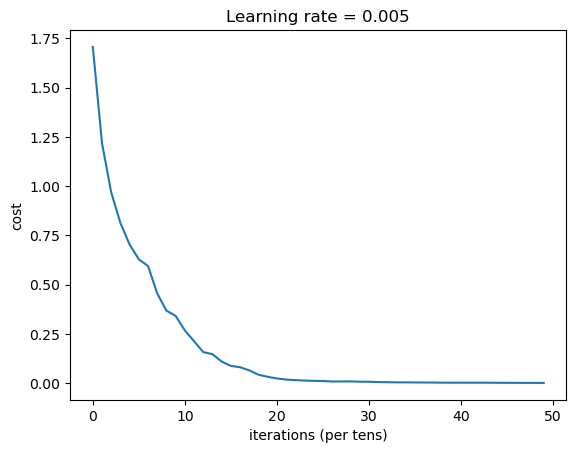

Train Accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
Test Accuracy: tf.Tensor(0.89166665, shape=(), dtype=float32)


In [13]:
_, _, network_model_trained = train_model(network_model, X_train_cast, Y_train, X_test_cast, Y_test, num_epochs=50)

Congratulations! You have finished the first part of this assignment and built a model that recognizes SIGNS language. If you wish, feel free to play around with this dataset further. You can actually improve its accuracy by spending more time tuning the hyperparameters, or using regularization (as this model clearly has a high variance). 

# Part II

## 3 - Experiment with a similar dataset! 

Here you will use a Dataset provided by TensorFlow in the [tensorflow_dataset module](https://www.tensorflow.org/datasets/catalog/overview), specifically the `rock_paper_scissors` dataset that is similar to the one used above in the notebook. 

The images in the dataset belong to the 3 different hand signs used in the rock-paper-scissors game.

If you want, you can free your memory by restarting the kernel and re-executing the `import` statements. 
Note that the last package to be imported is new with respect to the previously imported ones. If you have an error you probably need to install it: use `pip install tensorflow-datasets` and maybe also `pip install ipywidgets` is required.

In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
np.random.seed(4)

import tensorflow_datasets as tfds

### 3.1 - tf.data.Dataset API

TensorFlow datasets can be loaded using the [function](https://www.tensorflow.org/datasets/overview#tfdsload) `tfds.load` which creates a `tf.data.Dataset` [object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

The `tf.data.Dataset` API supports writing efficient input pipelines. In Lab 5 we will see how to load your own data into a `tf.data.Dataset` object.
In the rest of this notebook, you will use `tf.data.Dataset` to apply transformations to the input data and then you will train your neural network on the processed dataset.
In that respect, if you use `tf.data.Dataset`, iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

Load the training and test datasets from the TensorFlow dataset. 

In [15]:
(ds_train, ds_test), ds_info = tfds.load(name='rock_paper_scissors', with_info=True, as_supervised=True, split=[tfds.Split.TRAIN, tfds.Split.TEST], shuffle_files=False)

Note that here, as in part I of the notebook, we use only the training and the test sets for the sake of simplicity as we are not performing hyperparameter selection. In general, remember that three sets are needed for training, validation and test.

Visualize the dataset: run the cells below. 

In [16]:
print('Train dataset:', ds_train)
print('Train dataset size:', len(list(ds_train)), '\n')

print('Test dataset:', ds_test)
print('Test dataset size:', len(list(ds_test)), '\n')

Train dataset: <_OptionsDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Train dataset size: 2520 

Test dataset: <_OptionsDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Test dataset size: 372 



In [17]:
# Function to convert label ID to labels string.
get_label_name = ds_info.features['label'].int2str

In [18]:
def preview_dataset(dataset):
    
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

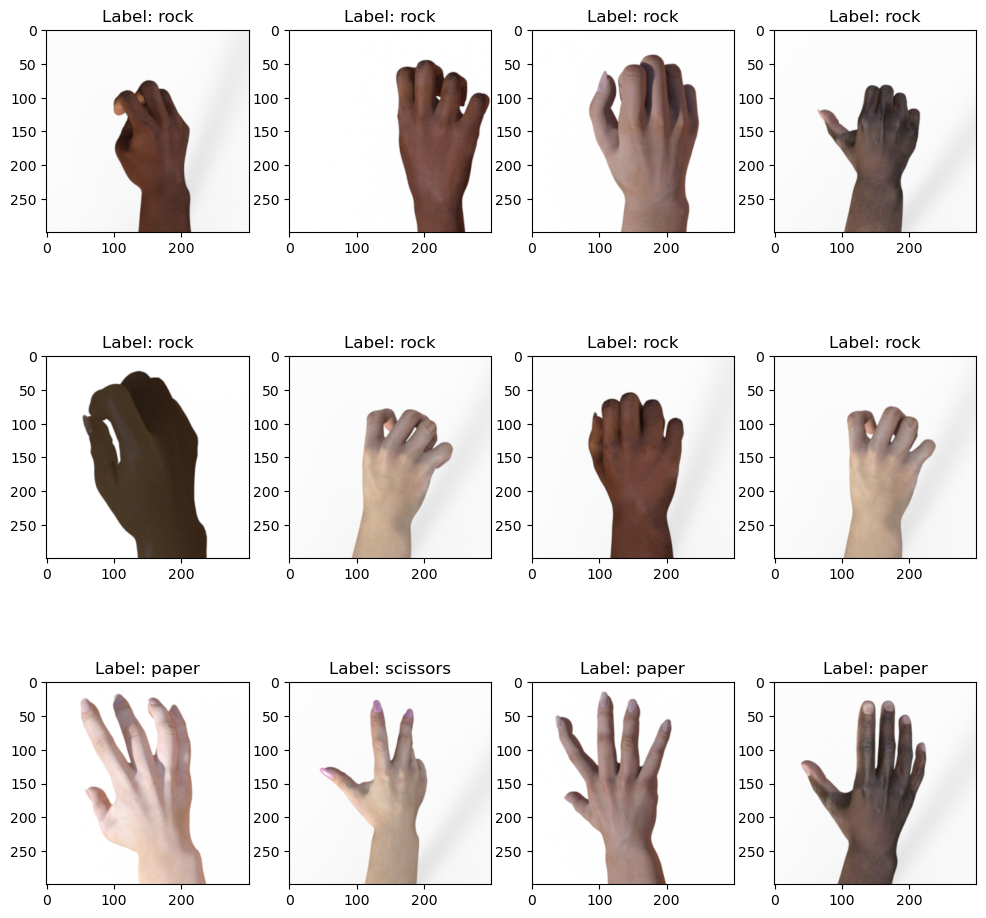

In [19]:
# Explore raw training dataset images
preview_dataset(ds_train)

### 3.2 - Prepare the dataset for training

The following function normalizes and converts the data into `tf.float32` values.

In [20]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

To apply the `normalize_img` to our `tf.data.Dataset` objects, we have to use the `map()` method (documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)) which allows applying transformations to the elements of the dataset. 

In [21]:
# Apply the normalize_img function to ds_train and ds_test
### START CODE HERE ### (2 lines)
ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)
### END CODE HERE ###

Here below are some `tf.data.Dataset` methods that are called to create the input pipeline for the training:

#### 3.2.1 - Caching
The first time the dataset is iterated over, its elements will be cached in a specified file or in memory. Subsequent iterations will use the cached data. Documentation can be found [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache).

#### 3.2.2 - Shuffling
This allows the data to be sampled in a different order on every epoch. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle). The shuffle operation should be performed only on the training set.

#### 3.2.3 - Batching
Put together *batch_size* samples into a single batch of data, which will be the input of the network. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch).

#### 3.2.4 - Prefetching 
While a process is training your network, this operation allows to load and process the subsequent chunk of data at the same time, greatly improving the idle time. Documentation [here](https://www.tensorflow.org/guide/data_performance#prefetching).
<img src="images/prefetch.png" style="height:300px;">

In [22]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
ds_test = ds_test.cache()
ds_test = ds_test.batch(32)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

### 3.3 - Define the network model
Use the same network model defined above but try to define it using `tensorflow.keras.models.Model`. You can find the reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

To do that we define the function `SignModel` and the `ConvPool` function just for convenience (and code reusability).

In [24]:
def ConvPool(X, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu', pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):
    """
    Help function for convolutional + max pooling layers
    
    Arguments:
    X -- imput tensor

    Returns:
    model -- a Model() instance in TensorFlow
    """
    ### START CODE HERE ###
    # CONV -> Batch Normalization -> ReLU Block applied to X (3 lines of code)
    X = tf.keras.layers.Conv2D(conv_feature_maps, conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)
    
    # MAXPOOL (1 line of code)
    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)
    ### END CODE HERE ###
    
    return X

In [25]:
# FUNCTION: SignModel

def SignModel(input_shape):
    """
    Implementation of the SignModel
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in TensorFlow
    """
    
    ### START CODE HERE ### (1 line of code for each instruction)
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # FIRST CONV + MAXPOOL BLOCK
    X = ConvPool(X_input, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu', pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')
    
    # SECOND CONV + MAXPOOL BLOCK
    X = ConvPool(X, conv_feature_maps=8, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu', pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    # FLATTEN THE TENSOR 
    X = tf.keras.layers.Flatten()(X)
    
    # FULLYCONNECTED (DENSE) LAYER WITH RELU ACTIVATION AND 16 OUTPUT NEURONS
    X = tf.keras.layers.Dense(16, activation='relu')(X)
    
    # DROPOUT LAYER (DISCARD PROBABILITY 0.4)
    X = tf.keras.layers.Dropout(0.4)(X)
    
    # DENSE LAYER WITHOUT ACTIVATION AND 3 OUTPUT NEURONS
    X = tf.keras.layers.Dense(3, activation=None)(X)
                                    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = tf.keras.Model(inputs = X_input, outputs = X, name='SignModel')
    ### END CODE HERE ###
    
    return model

Now create the model by calling the above implemented function.

In [26]:
# NETWORK MODEL

### START CODE HERE ### (1 line of code)
network_model_2 = SignModel((300, 300, 3))
### END CODE HERE ###

### 3.4 - Train the network

In this second part of the notebook we use the built-in functions (`compile()`, `fit()`) to train the network model (refer to the official [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model)).

Specifically, you need first to compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`

In [27]:
### START CODE HERE ### (1 line)
network_model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
### END CODE HERE ###

In the cell above, you used the argument `optimizer="adam"` for the `compile()` method. Using this approach, the default learning rate is used (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)).
If you want to change the learning rate, you have to create an object of one of the classes in the `tf.keras.optimizer` [module](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

As seen in the first part of this notebook, you can use the following command to define an Adam optimizer with a learning rate set to 0.0005:

```python
tf.keras.optimizers.Adam(learning_rate=0.0005)
```

The same applies to the `loss` argument, if you want to define your own loss function. 
Note that below we use the `SparseCategoricalCrossentropy` (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)) as the labels, in this case, are integers while in the above dataset they were one-hot encoded. 
Remember that, for the argument, the default option is `from_logits=False`: you need to change it if you did not include the activation in the last layer of the network:

```python
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
```

Let's try to run the compile method with a custom optimizer and loss function.

In [28]:
### START CODE HERE ### (3 lines of code)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_funct = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
network_model_2.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
### END CODE HERE ###

Now let's train the model on training data! Use the fit method: `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`

In [29]:
### START CODE HERE ### (1 line)
network_model_2.fit(ds_train, epochs=50, validation_data=ds_test)
### END CODE HERE ###

Epoch 1/50
79/79 [==============================] - 48s 553ms/step - loss: 0.8711 - accuracy: 0.5452 - val_loss: 1.1436 - val_accuracy: 0.3333
Epoch 2/50
79/79 [==============================] - 36s 451ms/step - loss: 0.6581 - accuracy: 0.6103 - val_loss: 1.0871 - val_accuracy: 0.3710
Epoch 3/50
79/79 [==============================] - 36s 459ms/step - loss: 0.6096 - accuracy: 0.6083 - val_loss: 1.0752 - val_accuracy: 0.4301
Epoch 4/50
79/79 [==============================] - 35s 446ms/step - loss: 0.5528 - accuracy: 0.6627 - val_loss: 1.0179 - val_accuracy: 0.5457
Epoch 5/50
79/79 [==============================] - 36s 453ms/step - loss: 0.5362 - accuracy: 0.6599 - val_loss: 0.9250 - val_accuracy: 0.6075
Epoch 6/50
79/79 [==============================] - 36s 455ms/step - loss: 0.5220 - accuracy: 0.6567 - val_loss: 0.8710 - val_accuracy: 0.6425
Epoch 7/50
79/79 [==============================] - 34s 437ms/step - loss: 0.4935 - accuracy: 0.6480 - val_loss: 0.9035 - val_accuracy: 0.6129

To test a trained model, you can use the method evaluate: `model.evaluate(x = ..., y = ...)` as follows.

In [30]:
### START CODE HERE ### (1 line)
preds = network_model_2.evaluate(ds_test)
### END CODE HERE ###
print("\nLoss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

12/12 [==============================] - 2s 137ms/step - loss: 4.0004 - accuracy: 0.6022

Loss = 4.000432968139648
Test Accuracy = 0.602150559425354


### 3.5 - Other useful TensorFlow instructions

- `model.save()`: save the trained model so that you can use it later
- `model.summary()`: prints the details of your layers in a table with the sizes of its inputs/outputs
- `plot_model()`: plots your graph in a nice layout.

Run the following code.

In [31]:
# Save the model
network_model_2.save('signModel.h5')
# Load the saved model
model_loaded = tf.keras.models.load_model('signModel.h5')

In [32]:
# Print the model information
network_model_2.summary()

Model: "SignModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 300, 300, 4)       112       
                                                                 
 batch_normalization_2 (Batc  (None, 300, 300, 4)      16        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 300, 300, 4)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 150, 150, 4)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 8)       29

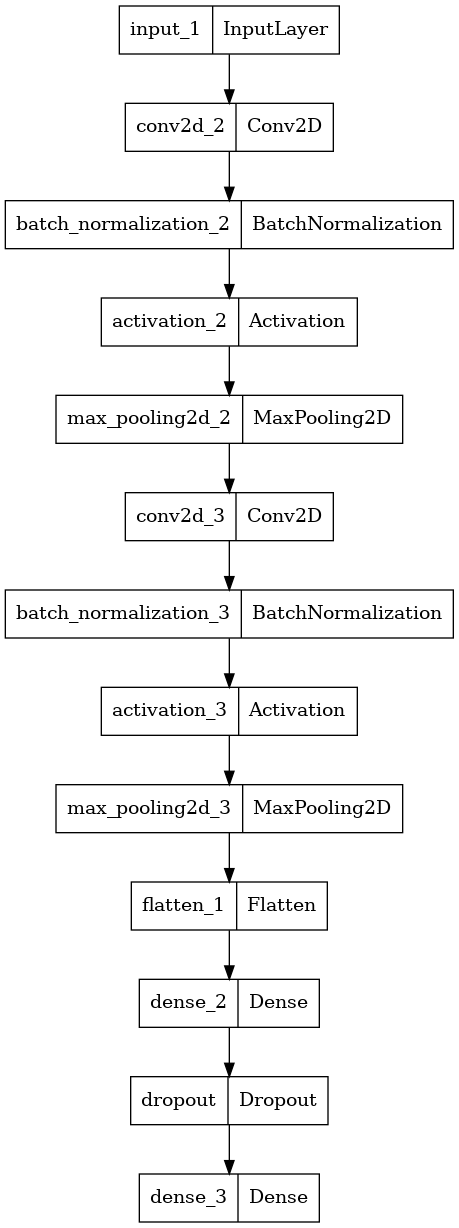

In [33]:
# Show the structure of the model through building blocks
tf.keras.utils.plot_model(network_model_2, to_file='signModel.png')

from IPython.display import Image
Image("signModel.png")

Congratulations! You have finished also the second part of this assignment and built a model that recognizes hand gestures from the rock-paper-scissors game.